# Example: N-steps-ahead prediction - F-16 Ground Vibration Test benchmark

**Note**: The following examples do not try to replicate the results of the cited manuscripts. Even the model parameters such as ylag and xlag and size of identification and validation data are not the same of the cited papers. Moreover, sampling rate adjustment and other different data preparation are not handled here.

**The following text was taken from the link http://www.nonlinearbenchmark.org/#F16**. 

**Note**: The reader is reffered to the mentioned website for a complete reference concerning the experiment. For now, this notebook is just a simple example of the performance of SysIdentPy on a real world dataset. A more detailed study of this system will be published in the future.  

> The F-16 Ground Vibration Test benchmark features a high order system with clearance and friction nonlinearities at the mounting interface of the payloads.

> The experimental data made available to the Workshop participants were acquired on a full-scale F-16 aircraft on the occasion of the Siemens LMS Ground Vibration Testing Master Class, held in September 2014 at the Saffraanberg military basis, Sint-Truiden, Belgium.

> During the test campaign, two dummy payloads were mounted at the wing tips to simulate the mass and inertia properties of real devices typically equipping an F-16 in ﬂight. The aircraft structure was instrumented with accelerometers. One shaker was attached underneath the right wing to apply input signals. The dominant source of nonlinearity in the structural dynamics was expected to originate from the mounting interfaces of the two payloads. These interfaces consist of T-shaped connecting elements on the payload side, slid through a rail attached to the wing side. A preliminary investigation showed that the back connection of the right-wing-to-payload interface was the predominant source of nonlinear distortions in the aircraft dynamics, and is therefore the focus of this benchmark study.

> A detailed formulation of the identification problem can be found here. All the provided files and information on the F-16 aircraft benchmark system are available for download here. This zip-file contains a detailed system description, the estimation and test data sets, and some pictures of the setup. The data is available in the .csv and .mat file format.

> Please refer to the F16 benchmark as:

> J.P. Noël and M. Schoukens, F-16 aircraft benchmark based on ground vibration test data, 2017 Workshop on Nonlinear System Identification Benchmarks, pp. 19-23, Brussels, Belgium, April 24-26, 2017.

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results

## Preparing the data

In [4]:
f_16 = pd.read_csv(
    r"../examples/datasets/f-16.txt", header=None, names=["x1", "x2", "y"]
)

In [5]:
f_16.shape

(32768, 3)

<Axes: >

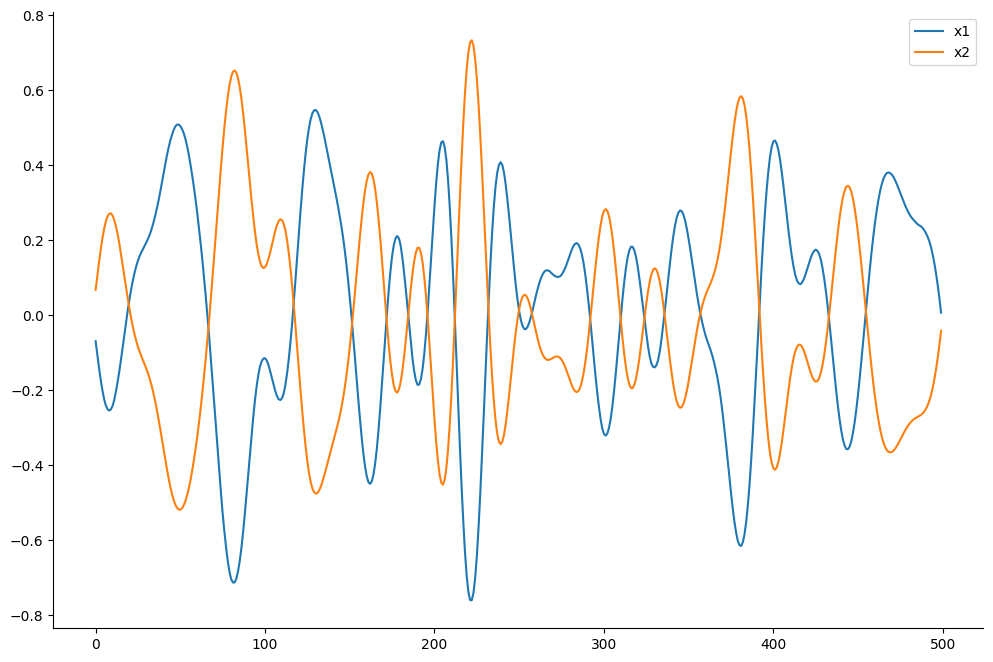

In [6]:
f_16[["x1", "x2"]][0:500].plot(figsize=(12, 8))

<Axes: >

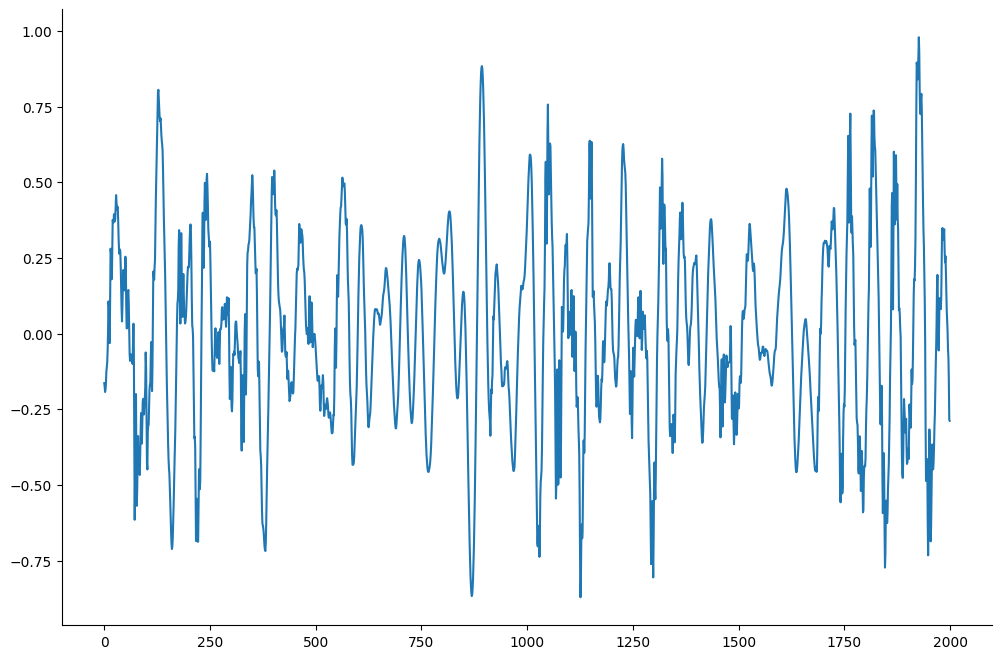

In [7]:
f_16["y"][0:2000].plot(figsize=(12, 8))

In [8]:
x1_id, x1_val = f_16["x1"][0:16384].values.reshape(-1, 1), f_16["x1"][
    16384::
].values.reshape(-1, 1)
x2_id, x2_val = f_16["x2"][0:16384].values.reshape(-1, 1), f_16["x2"][
    16384::
].values.reshape(-1, 1)
x_id = np.concatenate([x1_id, x2_id], axis=1)
x_val = np.concatenate([x1_val, x2_val], axis=1)

y_id, y_val = f_16["y"][0:16384].values.reshape(-1, 1), f_16["y"][
    16384::
].values.reshape(-1, 1)

In [9]:
x1lag = list(range(1, 10))
x2lag = list(range(1, 10))
x2lag

[1, 2, 3, 4, 5, 6, 7, 8, 9]

## Building the model

In [10]:
basis_function = Polynomial(degree=1)
estimator = LeastSquares()

model = FROLS(
    order_selection=True,
    n_info_values=39,
    ylag=20,
    xlag=[x1lag, x2lag],
    info_criteria="bic",
    estimator=estimator,
    basis_function=basis_function,
)

model.fit(X=x_id, y=y_id)

## Defining the forecasting horizon

To perform a n-steps-ahead prediction you just need to set the "steps_ahead" argument.

**Note** The default value for steps_ahead is None and it performs a infinity-steps-ahead prediction

0.09610207940697202
   Regressors   Parameters             ERR
0      y(k-1)   1.8387E+00  9.43378253E-01
1      y(k-2)  -1.8938E+00  1.95167599E-02
2      y(k-3)   1.3337E+00  1.02432261E-02
3      y(k-6)  -1.6038E+00  8.03485985E-03
4      y(k-9)   2.6776E-01  9.27874557E-04
5     x2(k-7)  -2.2385E+01  3.76837313E-04
6     x1(k-1)   8.2709E+00  6.81508210E-04
7     x2(k-3)   1.0587E+02  1.57459800E-03
8     x1(k-8)  -3.7975E+00  7.35086279E-04
9     x2(k-1)   8.5725E+01  4.85358786E-04
10     y(k-7)   1.3955E+00  2.77245281E-04
11     y(k-5)   1.3219E+00  8.64120037E-04
12    y(k-10)  -2.9306E-01  8.51717688E-04
13     y(k-4)  -9.5479E-01  7.23623116E-04
14     y(k-8)  -7.1309E-01  4.44988077E-04
15    y(k-12)  -3.0437E-01  1.49743148E-04
16    y(k-11)   4.8602E-01  3.34613282E-04
17    y(k-13)  -8.2442E-02  1.43738964E-04
18    y(k-15)  -1.6762E-01  1.25546584E-04
19    x1(k-2)  -8.9698E+00  9.76699739E-05
20    y(k-17)   2.2036E-02  4.55983807E-05
21    y(k-14)   2.4900E-01  1.1031

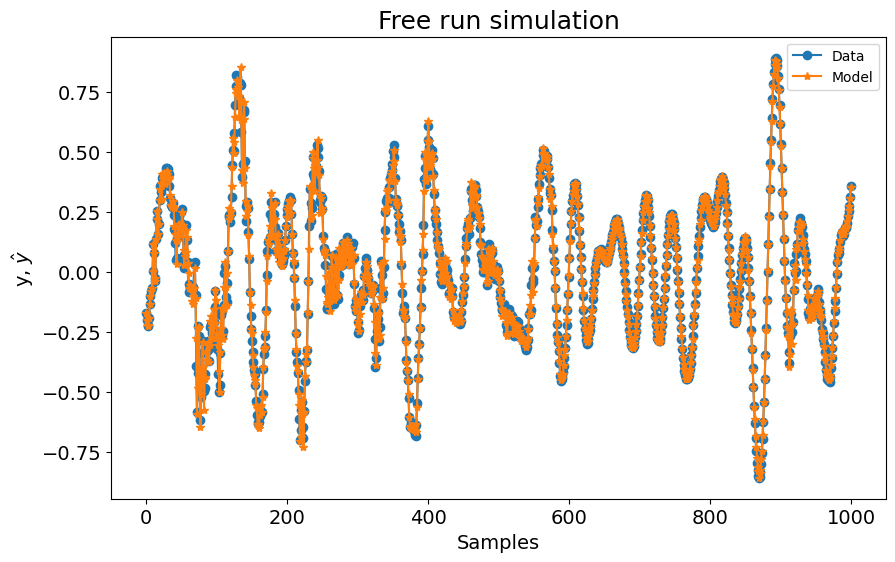

In [11]:
y_hat = model.predict(X=x_val, y=y_val, steps_ahead=1)
rrse = root_relative_squared_error(y_val, y_hat)
print(rrse)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_val, yhat=y_hat, n=1000)

0.2168472873799118


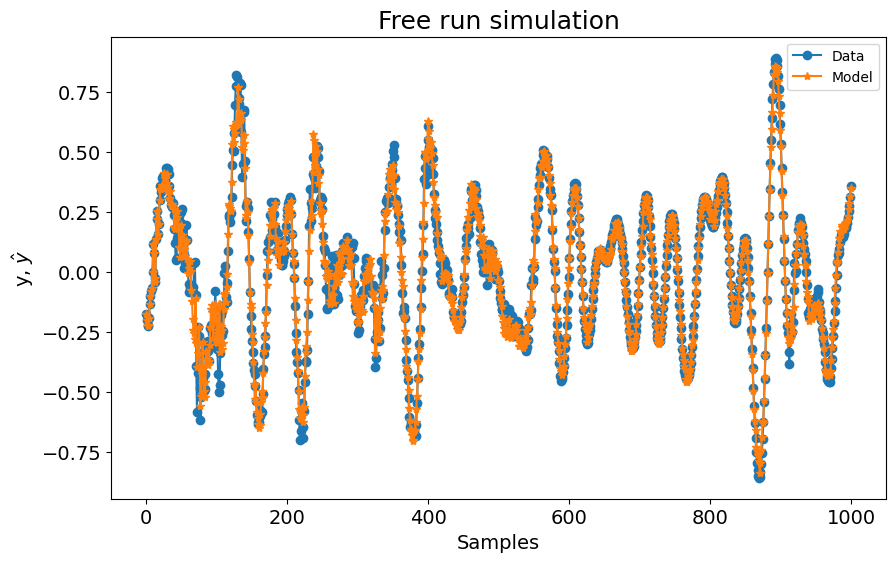

In [12]:
y_hat = model.predict(X=x_val, y=y_val, steps_ahead=5)
rrse = root_relative_squared_error(y_val, y_hat)
print(rrse)
plot_results(y=y_val, yhat=y_hat, n=1000)

0.2910089654603829


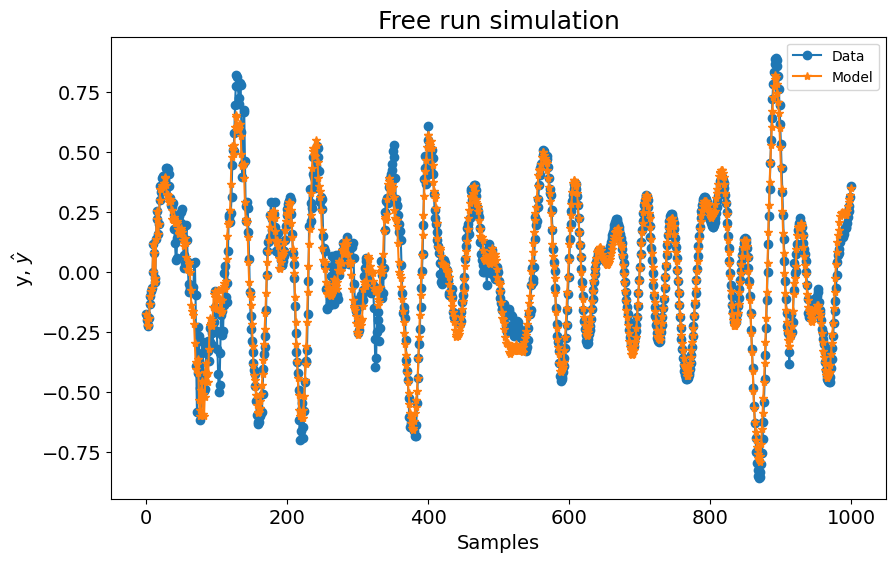

In [13]:
y_hat = model.predict(X=x_val, y=y_val, steps_ahead=None)
rrse = root_relative_squared_error(y_val, y_hat)
print(rrse)
plot_results(y=y_val, yhat=y_hat, n=1000)